In [4]:
!curl -o 'weather-2016.html' \
    -d 'messw_beg=01.01.2016&messw_end=31.12.2016&felder[]=Temp2m&felder[]=TempWasser&felder[]=Windchill&felder[]=LuftdruckQFE&felder[]=Regen&felder[]=Taupunkt&felder[]=Strahlung&felder[]=Feuchte&felder[]=Pegel&auswahl=2&combilog=mythenquai&suchen=Werte anzeigen' \
    -e 'https://www.tecson-data.ch/zurich/mythenquai/index.php' \
    -X POST 'https://www.tecson-data.ch/zurich/mythenquai/uebersicht/messwerte.php'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 60.1M    0 60.1M  100   254  10.9M     46  0:00:05  0:00:05 --:--:-- 11.8M00:03  0:00:03 --:--:-- 10.3M


In [5]:
%matplotlib inline
import pandas as pd

In [6]:
df = pd.read_html(open('weather-2016.html', encoding='iso-8859-1'),
                  attrs={'border': '1'},
                  skiprows=1, parse_dates=True, index_col=0)
df = df[0]

In [7]:
df.columns = ['Temp', 'WaterTemp', 'Windchill', 'Pressure', 'Rain',
              'Dewpoint', 'Radiation', 'Humidity', 'Waterlevel']
df.head()

,Temp,WaterTemp,Windchill,Pressure,Rain,Dewpoint,Radiation,Humidity,Waterlevel
0,,,,,,,,,
2016-01-01 00:00:00,6.3,7.2,6.3,977.0,0.0,6.0,0,98,405.79
2016-01-01 00:10:00,6.3,7.2,6.3,977.0,0.0,6.0,0,98,405.79
2016-01-01 00:20:00,6.3,7.2,6.3,977.0,0.0,6.0,0,98,405.79
2016-01-01 00:30:00,6.4,7.2,6.4,977.1,0.0,6.1,0,98,405.78
2016-01-01 00:40:00,6.4,7.2,6.4,977.1,0.0,6.2,0,98,405.79


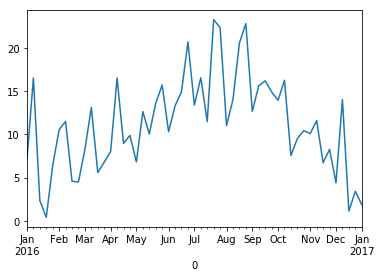

In [8]:
temperature = df['Temp']
temperature.resample('W').mean().plot();

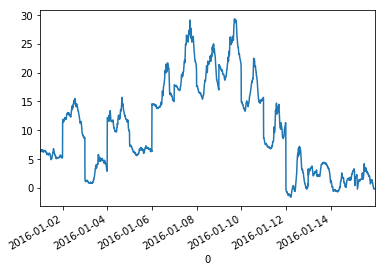

In [9]:
temperature[:"01/15/2016"].plot()

Something is not right ...

In [10]:
pd.to_datetime('01.08.2016 00:00:00')

Timestamp('2016-01-08 00:00:00')

In [11]:
pd.to_datetime('01.08.2016 00:00:00', dayfirst=True)

Timestamp('2016-08-01 00:00:00')

## Attempt two

We load the data without trying to parse the dates automatically. Instead we specify explicitly the format (day first) when we convert the first column to a datetime.

In [12]:
df = pd.read_html(open('weather-2016.html', encoding='iso-8859-1'),
                  attrs={'border': '1'},
                  skiprows=1)
df = df[0]

In [13]:
df[0] = pd.to_datetime(df[0], dayfirst=True)

In [14]:
df.columns = ['Date', 'Temp', 'WaterTemp', 'Windchill', 'Pressure', 'Rain',
              'Dewpoint', 'Radiation', 'Humidity', 'Waterlevel']
df = df.set_index('Date')

In [15]:
df.head(5)

,Temp,WaterTemp,Windchill,Pressure,Rain,Dewpoint,Radiation,Humidity,Waterlevel
Date,,,,,,,,,
2016-01-01 00:00:00,6.3,7.2,6.3,977.0,0.0,6.0,0,98,405.79
2016-01-01 00:10:00,6.3,7.2,6.3,977.0,0.0,6.0,0,98,405.79
2016-01-01 00:20:00,6.3,7.2,6.3,977.0,0.0,6.0,0,98,405.79
2016-01-01 00:30:00,6.4,7.2,6.4,977.1,0.0,6.1,0,98,405.78
2016-01-01 00:40:00,6.4,7.2,6.4,977.1,0.0,6.2,0,98,405.79


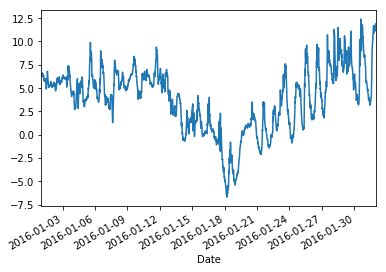

In [16]:
temperature = df['Temp']
temperature[:"20160131"].plot()

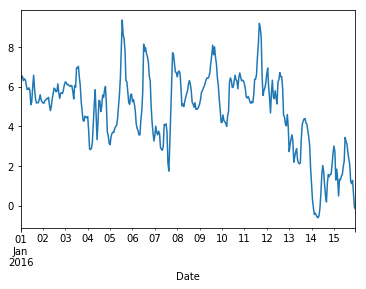

In [17]:
temperature['20160101':'20160115'].resample('H').mean().plot();

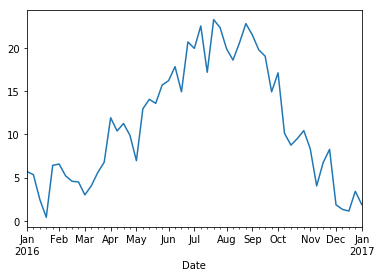

In [18]:
temperature.resample('W').mean().plot();

In [ ]:
temperature['20160118':"20160119"].plot()

In [ ]:
hourly = temperature.resample('H').mean()
hourly.groupby(hourly.index.time).mean().plot();

In [ ]:
df[['WaterTemp', 'Temp']].resample('W').mean().plot();

In [ ]:
df[['Radiation',]]['20160501':'20160531'].resample('H').mean().plot();

In [28]:
pd.read_csv("holidays.csv", parse_dates=True, index_col=0)

,Name
Date,
2015-01-01,Neujahrstag
2015-01-02,Berchtoldstag
2015-02-14,Valentinstag
2015-04-03,Karfreitag
2015-04-05,Ostern
2015-04-06,Osternmontag
2015-04-13,Sechselaeuten
2015-05-01,Tag der Arbeit
2015-05-10,Muttertag
